### Step 1: Load and Inspect the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
from PIL import Image
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING logs

2025-06-20 02:35:27.851143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750386928.059825      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750386928.115271      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV
csv_path = "/kaggle/input/butterfly-image-classification/Training_set.csv"
train_path = '/kaggle/input/butterfly-image-classification/train'
df = pd.read_csv(csv_path)

# Preview the dataframe
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [3]:
# Number of unique classes
unique_classes = df['label'].unique()
print(f"Number of unique butterfly classes: {len(unique_classes)}")

# Class distribution
class_counts = df['label'].value_counts()
print(class_counts)

Number of unique butterfly classes: 75
label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
SCARCE SWALLOW     97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64


In [4]:
import json

# Create a mapping of class index to label
class_to_index = {label: idx for idx, label in enumerate(sorted(unique_classes))}
index_to_class = {v: k for k, v in class_to_index.items()}

# Save to JSON
with open("class_list.json", "w") as f:
    json.dump(index_to_class, f)

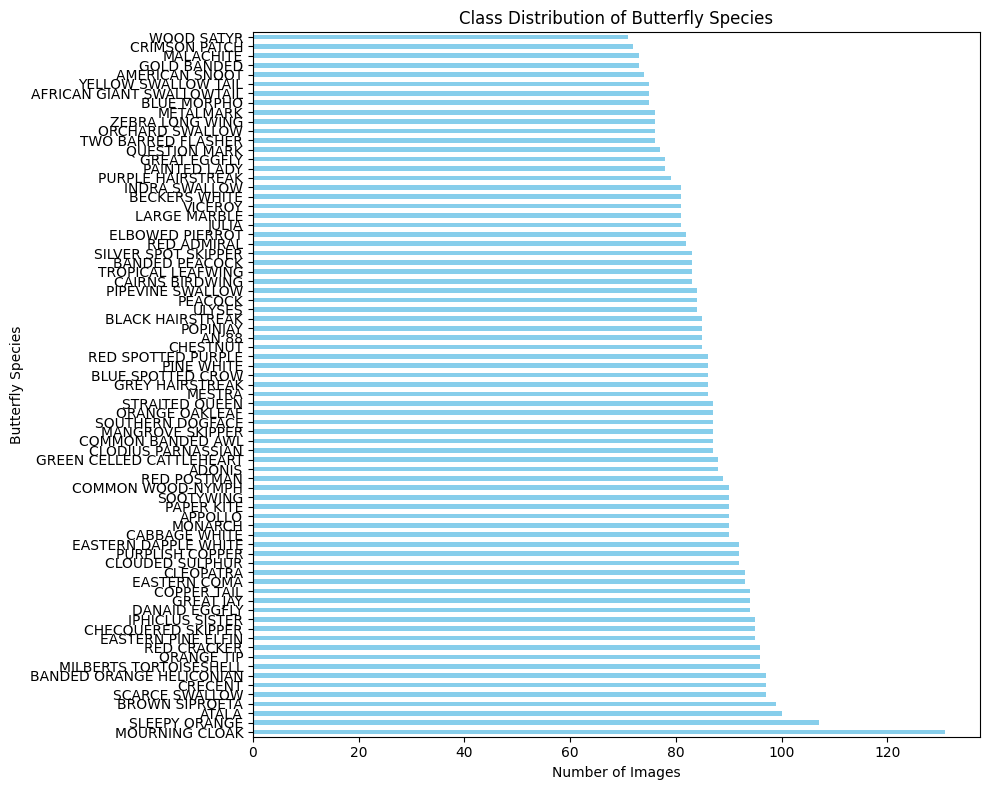

In [5]:
class_counts.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Class Distribution of Butterfly Species")
plt.xlabel("Number of Images")
plt.ylabel("Butterfly Species")
plt.tight_layout()
plt.show()

### EDA - Plot Image Dimensions

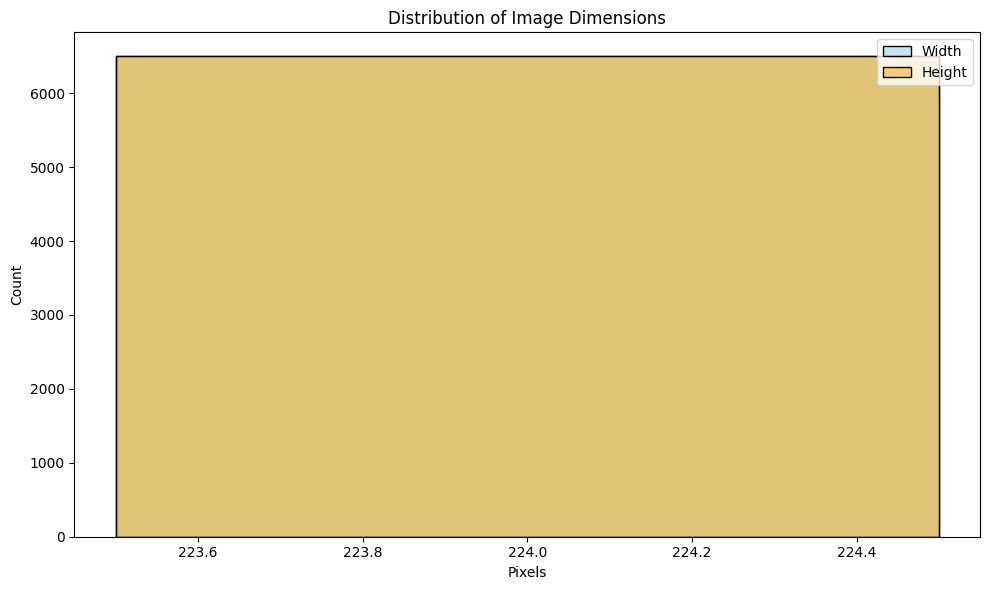

In [6]:
# Get image dimensions
widths, heights = [], []

for filename in tqdm(df['filename'], desc="Collecting image sizes"):
    img_path = os.path.join(train_path, filename)
    with Image.open(img_path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

# Add to DataFrame
df['width'] = widths
df['height'] = heights

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['width'], kde=True, color='skyblue', label='Width')
sns.histplot(df['height'], kde=True, color='orange', label='Height')
plt.title("Distribution of Image Dimensions")
plt.xlabel("Pixels")
plt.legend()
plt.tight_layout()
plt.show()

### Resize and Augment to Balance Classes

In [7]:
# Target size
TARGET_SIZE = (224, 224)
AUG_PER_CLASS = 100
output_dir = "/kaggle/working/resized_balanced"

os.makedirs(output_dir, exist_ok=True)

In [8]:
# Custom augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Count current samples per class
class_counts = Counter(df['label'])

# Create balanced dataset
balanced_data = []

for label in tqdm(df['label'].unique(), desc="Balancing classes"):
    class_df = df[df['label'] == label]
    images = []

    # Load & resize original images
    for _, row in class_df.iterrows():
        img_path = os.path.join(train_path, row['filename'])
        with Image.open(img_path) as img:
            img = img.convert("RGB").resize(TARGET_SIZE)
            images.append(np.array(img))

    images = np.array(images)
    n_existing = len(images)

    # Save original resized
    for i, img in enumerate(images):
        out_path = os.path.join(output_dir, f"{label}_{i}.jpg")
        Image.fromarray(img).save(out_path)
        balanced_data.append((out_path, label))

    # Generate augmented images
    if n_existing < AUG_PER_CLASS:
        n_to_aug = AUG_PER_CLASS - n_existing
        aug_iter = datagen.flow(images, batch_size=1)
        for i in range(n_to_aug):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            out_path = os.path.join(output_dir, f"{label}_aug_{i}.jpg")
            Image.fromarray(aug_img).save(out_path)
            balanced_data.append((out_path, label))

print("Balancing Completed!")

Balancing classes: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]

Balancing Completed!


### Prepare Data Pipeline

In [10]:
# Create balanced DataFrame
balanced_df = pd.DataFrame(balanced_data, columns=["filepath", "label"])
balanced_df.to_csv("balanced_df.csv")
balanced_df.head()

,filepath,label
0,/kaggle/working/resized_balanced/SOUTHERN DOGF...,SOUTHERN DOGFACE
1,/kaggle/working/resized_balanced/SOUTHERN DOGF...,SOUTHERN DOGFACE
2,/kaggle/working/resized_balanced/SOUTHERN DOGF...,SOUTHERN DOGFACE
3,/kaggle/working/resized_balanced/SOUTHERN DOGF...,SOUTHERN DOGFACE
4,/kaggle/working/resized_balanced/SOUTHERN DOGF...,SOUTHERN DOGFACE


In [11]:
# Train-test split
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df["label"], random_state=42)

# Image generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=TARGET_SIZE, class_mode='categorical', shuffle=True, batch_size=32
)

with open("class_indices.json", "w") as f:
    json.dump(train_loader.class_indices, f)

val_loader = val_gen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=TARGET_SIZE, class_mode='categorical', shuffle=False, batch_size=32
)

Found 6030 validated image filenames belonging to 75 classes.
Found 1508 validated image filenames belonging to 75 classes.


In [12]:
print(train_loader.class_indices)
print(train_loader.samples)
print(val_loader.samples)

{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ATALA': 5, 'BANDED ORANGE HELICONIAN': 6, 'BANDED PEACOCK': 7, 'BECKERS WHITE': 8, 'BLACK HAIRSTREAK': 9, 'BLUE MORPHO': 10, 'BLUE SPOTTED CROW': 11, 'BROWN SIPROETA': 12, 'CABBAGE WHITE': 13, 'CAIRNS BIRDWING': 14, 'CHECQUERED SKIPPER': 15, 'CHESTNUT': 16, 'CLEOPATRA': 17, 'CLODIUS PARNASSIAN': 18, 'CLOUDED SULPHUR': 19, 'COMMON BANDED AWL': 20, 'COMMON WOOD-NYMPH': 21, 'COPPER TAIL': 22, 'CRECENT': 23, 'CRIMSON PATCH': 24, 'DANAID EGGFLY': 25, 'EASTERN COMA': 26, 'EASTERN DAPPLE WHITE': 27, 'EASTERN PINE ELFIN': 28, 'ELBOWED PIERROT': 29, 'GOLD BANDED': 30, 'GREAT EGGFLY': 31, 'GREAT JAY': 32, 'GREEN CELLED CATTLEHEART': 33, 'GREY HAIRSTREAK': 34, 'INDRA SWALLOW': 35, 'IPHICLUS SISTER': 36, 'JULIA': 37, 'LARGE MARBLE': 38, 'MALACHITE': 39, 'MANGROVE SKIPPER': 40, 'MESTRA': 41, 'METALMARK': 42, 'MILBERTS TORTOISESHELL': 43, 'MONARCH': 44, 'MOURNING CLOAK': 45, 'ORANGE OAKLEAF': 46, 'ORANGE TI

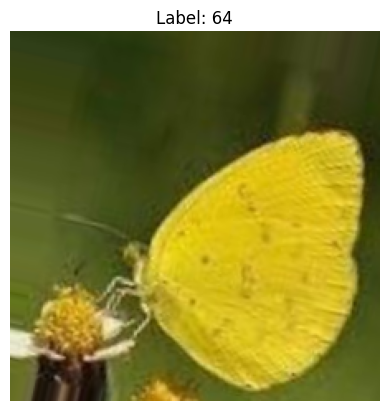

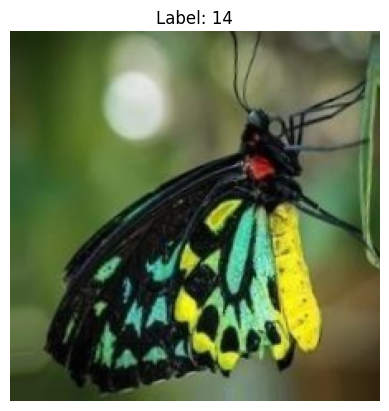

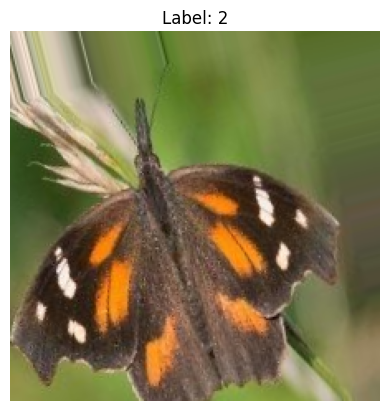

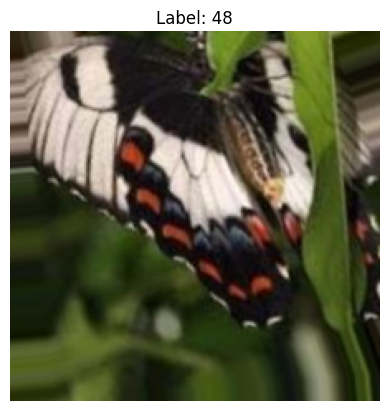

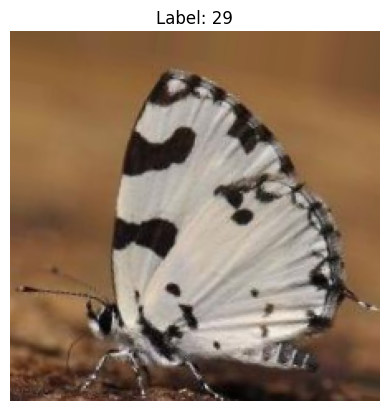

In [13]:
import matplotlib.pyplot as plt

imgs, labels = next(train_loader)
for i in range(5):
    plt.imshow(imgs[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")
    plt.show()

### Build Model and Train on TPU

In [14]:
# Use TPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
except:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )

    # Unfreeze top 50 layers
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(train_loader.class_indices), activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

I0000 00:00:1750387009.602595      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 75)                  │          19,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,064,459 (11.69 MB)

 Trainable params: 2,661,579 (10.15 MB)

 Non-trainable params: 402,880 (1.54 MB)

### Add Callbacks and Train

In [15]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [16]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "butterfly_classifier.keras", save_best_only=True, monitor='val_accuracy', mode='max'
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Train
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/30


I0000 00:00:1750387029.150976      63 service.cc:148] XLA service 0x793abc159b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750387029.151837      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750387030.806765      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750387034.268187      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750387034.465644      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:25:00 27s/step - accuracy: 0.0000e+00 - loss: 4.7120

I0000 00:00:1750387039.972966      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 36/189 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.0197 - loss: 4.4948

E0000 00:00:1750387053.772937      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750387053.968891      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 389ms/step - accuracy: 0.0774 - loss: 4.1315 - val_accuracy: 0.5007 - val_loss: 2.5295 - learning_rate: 1.0000e-04
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 60s 318ms/step - accuracy: 0.5285 - loss: 1.9390 - val_accuracy: 0.7149 - val_loss: 1.0647 - learning_rate: 1.0000e-04
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.7549 - loss: 0.9453 - val_accuracy: 0.8123 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 61s 325ms/step - accuracy: 0.8466 - loss: 0.5859 - val_accuracy: 0.8495 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 60s 316ms/step - accuracy: 0.8911 - loss: 0.4146 - val_accuracy: 0.8800 - val_loss: 0.4064 - learning_rate: 1.0000e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step - accuracy: 0.9192 - loss: 0.2986 - val_accuracy: 0.8952 - val_loss: 0.3741 - learning_rate: 1.0000e-04
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step -

### Load Model and Class Indices

In [17]:
# Load trained model
model = tf.keras.models.load_model("/kaggle/working/butterfly_classifier.keras")

# Load class index mapping
with open("/kaggle/working/class_indices.json") as f:
    class_indices = json.load(f)

# Invert to get: index → label
index_to_class = {v: k for k, v in class_indices.items()}

In [18]:
# Load CSV
csv_path = "/kaggle/input/butterfly-image-classification/Testing_set.csv"
test_path = "/kaggle/input/butterfly-image-classification/test"
df = pd.read_csv(csv_path)

# Store predictions
pred_labels = []

for filename in tqdm(df['filename'], desc="Predicting"):
    img_path = os.path.join(test_path, filename)
    
    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_label = index_to_class[pred_class]
    pred_labels.append(pred_label)

# Add predictions to the DataFrame
df['predicted_label'] = pred_labels
df.head()

Predicting: 100%|██████████| 2786/2786 [04:03<00:00, 11.46it/s]


,filename,predicted_label
0,Image_1.jpg,PINE WHITE
1,Image_2.jpg,CRIMSON PATCH
2,Image_3.jpg,ADONIS
3,Image_4.jpg,IPHICLUS SISTER
4,Image_5.jpg,MILBERTS TORTOISESHELL
